<a href="https://colab.research.google.com/github/LongNguyen1984/TimeSeriesWithPython/blob/main/TwoVariablePPGGlucoseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
**This use a 2-varible model to predict gluocse**
Y = $\alpha_1$*$X_1$ + $\alpha_2$*$X_2$ + $\beta$

Where: 
  * $X_1$: DC level of PPG
  * $X_2$: Pulse Transition Time (PTT) of PPG


##Import and Load PPG data

The PPG data has 4 channels with a sampling rate 70
 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

import pandas as pd
ppg  = pd.read_csv('drive/MyDrive/Dataset/long2aprilgLab1.csv', header=0)
# print out 20 first row of PPG
ppg.head(20)

,850nm,640nm,940nm,580nm,Channel 5,Channel 6,Channel 7,Channel 8
0,380947,-806209,773997,-1030610.0,0,0,0,0
1,381395,-805884,774766,-1030310.0,0,0,0,0
2,381363,-805342,774999,-1030570.0,0,0,0,0
3,381214,-805496,774037,-1030260.0,0,0,0,0
4,381299,-806230,773079,-1030070.0,0,0,0,0
5,381442,-805602,773045,-1029390.0,0,0,0,0
6,381112,-805621,772069,-1030100.0,0,0,0,0
7,381633,-806033,772478,-1029520.0,0,0,0,0
8,381608,-805229,773849,-1030160.0,0,0,0,0
9,381381,-806211,773961,-1030110.0,0,0,0,0


### Read PPG at 525nm


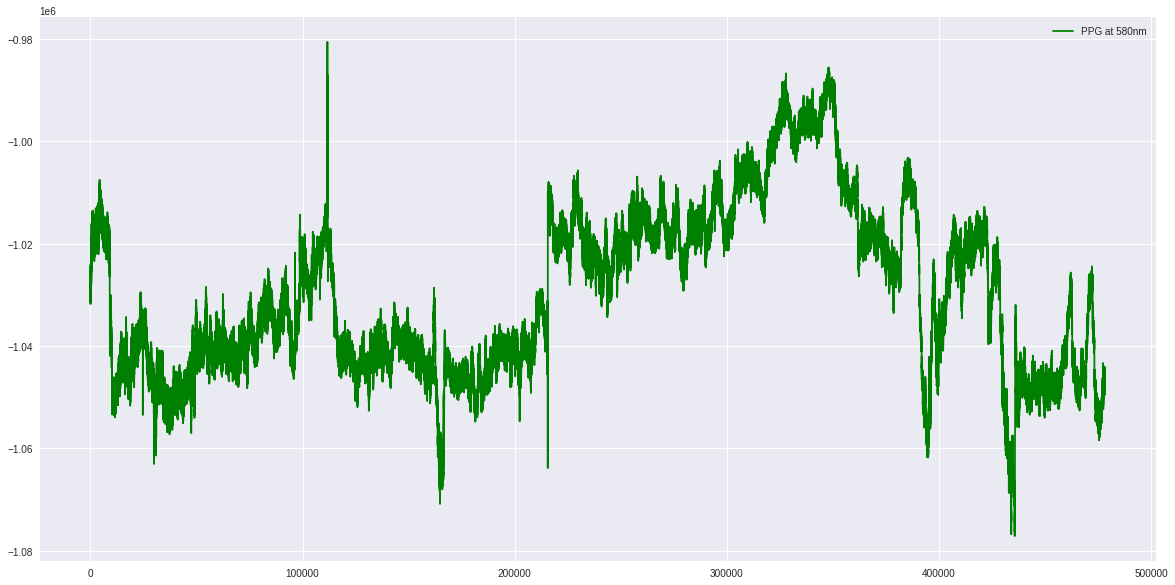

In [2]:
plt.style.use('seaborn')
name = '580nm'
#name = '940nm'
ppg525 = ppg[name][0:]
plt.figure(1, figsize=(20,10))
# colors for the line plot
colors = ['green', 'red', 'purple']

plt.plot(ppg525, "g-", label='PPG at ' + str(name))
plt.legend()

####Check Outliner

In [3]:
low = .0005
high = .9995
quant_df = ppg525.quantile([low, high])
print(quant_df)

0.0005   -1071890.0
0.9995    -987288.0
Name: 580nm, dtype: float64


###Remove Outliner

In [4]:
index = (ppg525.values < quant_df[high])
fal_idx = ~ index
ppg525[fal_idx] = np.nan

In [5]:
#interpolation
ppg525.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

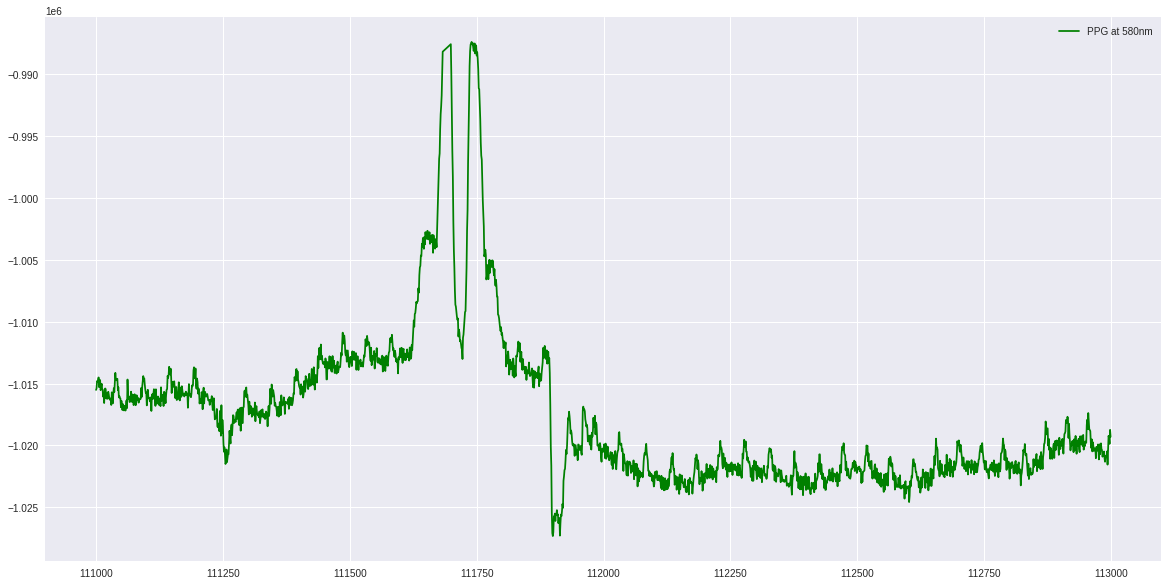

In [6]:
plt.figure(1, figsize=(20,10))
plt.plot(ppg525[111000:113000], "g-", label='PPG at '+str(name))
plt.legend()

###Filtering with S-Golay filter

In [7]:
from scipy.signal import savgol_filter
filter_PPG = savgol_filter(ppg525, 25, 7, mode='nearest')

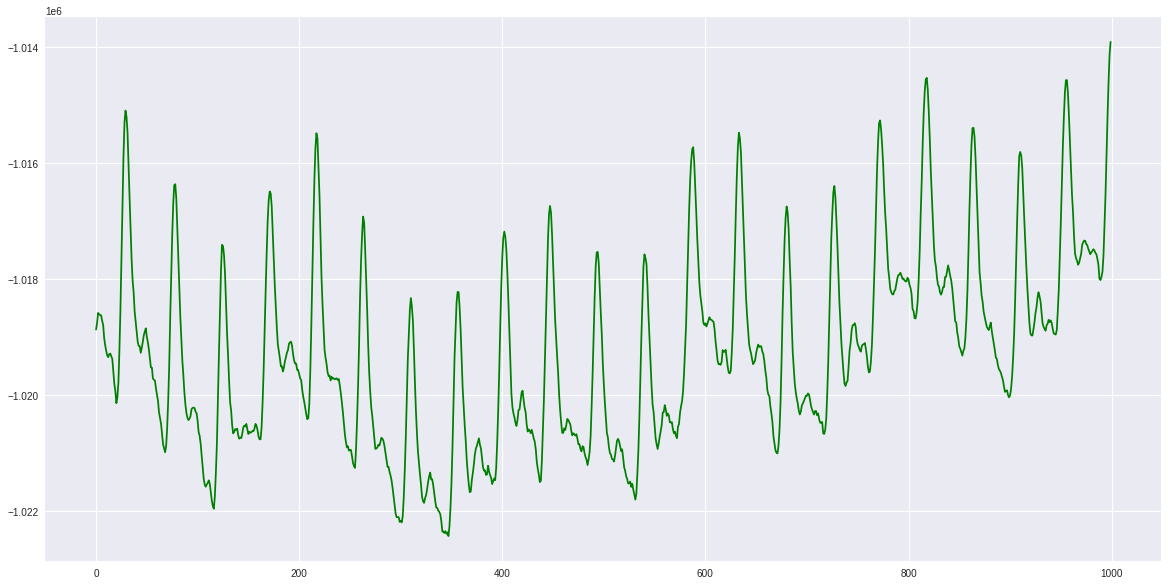

In [8]:
plt.figure(1, figsize=(20,10))
plt.plot(filter_PPG[1500:2500], "g-", label='PPG at 525nm')

# Detect peak

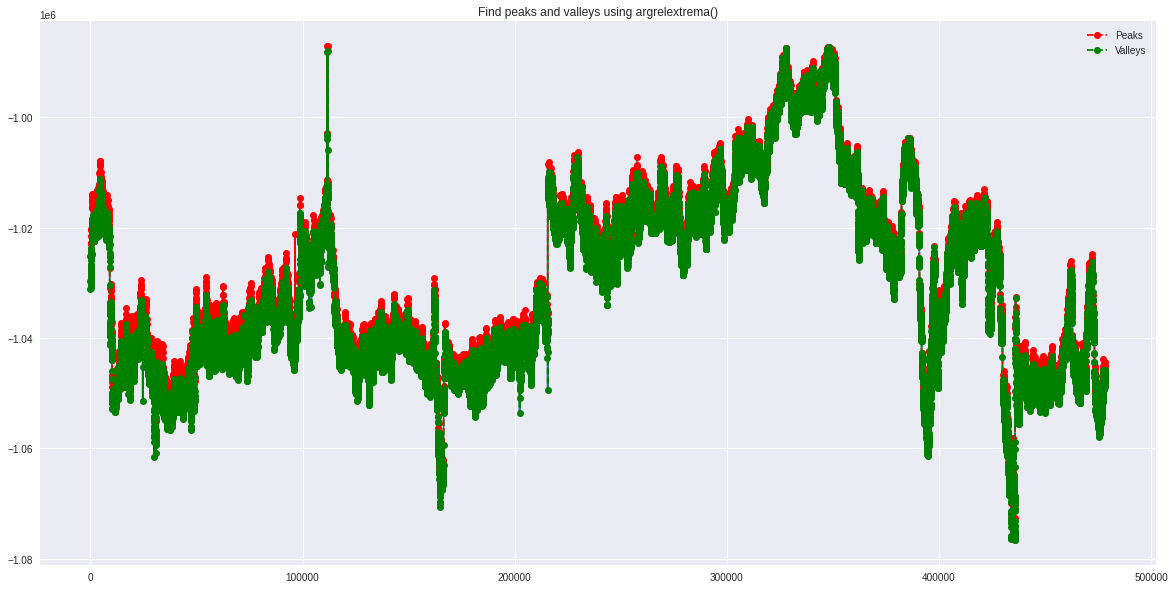

In [9]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

L1, L2 = 0, len(filter_PPG)
# find peak max
peak_idxs = signal.argrelextrema(filter_PPG, np.greater,order=18)
peak_idxs = peak_idxs[0]
peak_idxs = [i  for i in peak_idxs if (i >=L1 and i <=L2)]

#find peak min
valley_idxs = signal.argrelextrema(filter_PPG, np.less,order=1)
valley_idxs = valley_idxs[0]
valley_idxs = [i  for i in valley_idxs if (i >=L1 and i <=L2)]
#plot main graph
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(filter_PPG[L1:L2])
# plot peaks
peak_x = [i - L1 for i in peak_idxs]
peak_y =  filter_PPG[peak_idxs]
ax.plot(peak_x, peak_y, marker='o', linestyle='dashed', color='r', label='Peaks')
# plot valleys
valley_x = [i - L1 for i in valley_idxs]
valley_y =  filter_PPG[valley_idxs]
ax.plot(valley_x, valley_y, marker='o', linestyle='dashed', color='g', label='Valleys')

# Save graph to file.
plt.title('Find peaks and valleys using argrelextrema()')
plt.legend(loc='best')
#plt.savefig('argrelextrema.png')

In [10]:
len(peak_y), len(valley_y)

(10011, 59564)

### Reselecting valleys


In [11]:
def select_valley(peaks,valleys,sel='backward'):
  assert len(peaks) < len(valleys), "Need the valley set bigger than the peak set."
  assert len(valleys) > 2, "Need the valley set at least 2 element."
  assert len(peaks) > 1, "Need the valley set at least 1 element."
  val = []
   
  if sel =='backward':
    idx = 0 #position of valley smaller than peaks
    for p in peaks:
      for v,v_next in zip(valleys[idx:-1], valleys[idx+1:]):
        if v < p and v_next > p:
          val.append(v)
          idx = valleys.index(v)
          break
  elif sel == 'forward':
    idx = 1 #position of valley smaller than peaks
    for p in peaks:
      for v,v_next in zip(valleys[idx:], valleys[idx-1:-1]):
        if v > p and v_next < p:
          val.append(v)
          idx = valleys.index(v)
          break
      #elif ((v < p) and ((v - val[-1])> np.mean(np.diff(val)*0.9))):
      #  val.append(v)
  #if (valleys[-1] - val[-1])>np.mean(np.diff(val))*0.8:
  #  val.append(valleys[-1])
  return val

## Select vally close to peak set
val = select_valley(peak_idxs,valley_idxs, sel='backward') #'forward'

In [12]:
len(val), len(peak_idxs), len(valley_idxs)

(10010, 10011, 59564)

#### Draw in region (L1, L2)

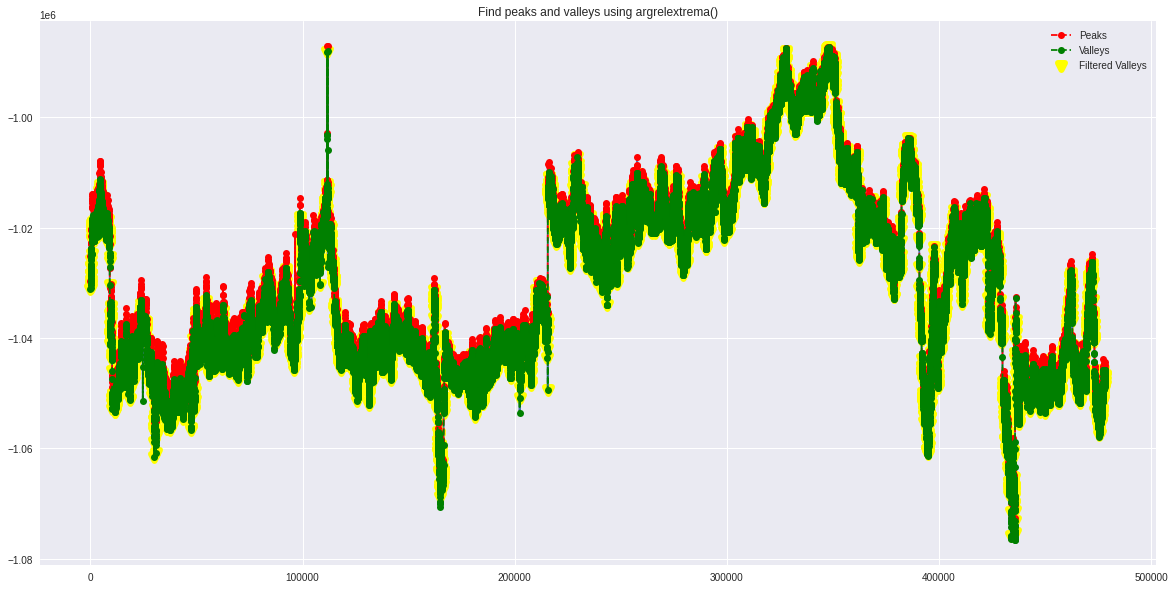

In [13]:
#L1, L2 = 111000, 113000#len(filter_PPG)
L1, L2 = 0, len(filter_PPG)
#plot main graph
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(filter_PPG[L1:L2])
# plot peaks
peak_x = [i - L1 for i in peak_idxs if i>=L1 and i < L2]
peak_y =  filter_PPG[np.array(peak_x)+L1]
ax.plot(peak_x, peak_y, marker='o', linestyle='dashed', color='r', label='Peaks')
# plot valleys
valley_x = [i - L1 for i in valley_idxs if i>=L1 and i < L2]
valley_y =  filter_PPG[np.array(valley_x)+L1 ]
ax.plot(valley_x, valley_y, marker='o', linestyle='dashed', color='g', label='Valleys')
# plot filterd valleys
valley_filtx = [i - L1 for i in val if i>=L1 and i < L2]
valley_filty =  filter_PPG[np.array(valley_filtx)+L1]
ax.scatter(valley_filtx, valley_filty, marker='v', linewidth=6, color='yellow', label='Filtered Valleys')
# Save graph to file.
plt.title('Find peaks and valleys using argrelextrema()')
plt.legend(loc='best')
#plt.savefig('argrelextrema.png')

### Draw difference Peak-Valley

In [14]:
peak_y[0], valley_y[0],len(peak_y), len(valley_y)

(-1029744.2952782897, -1031212.2682899128, 10011, 59564)

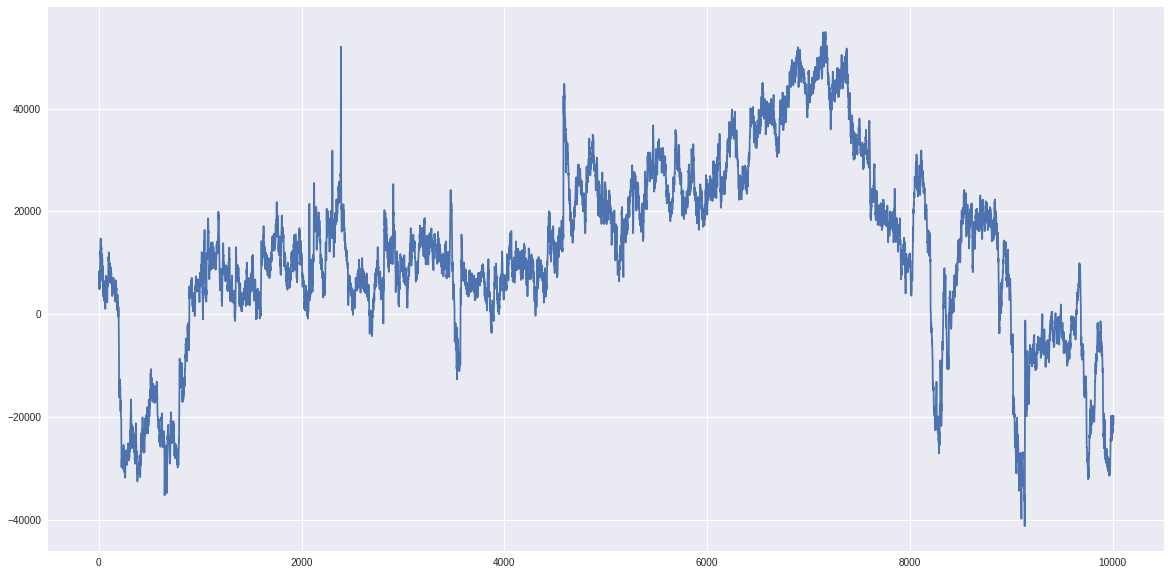

In [15]:
L = min(len(peak_y), len(valley_y))

z = np.array(peak_y[1:L]) - np.array(valley_y[0:L-1])

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(z)




In [16]:
dz = np.gradient(z)
df_z = pd.DataFrame(dz)
df_z.index = [x for x in range(0, len(df_z.values))]
#df_z == np.nan

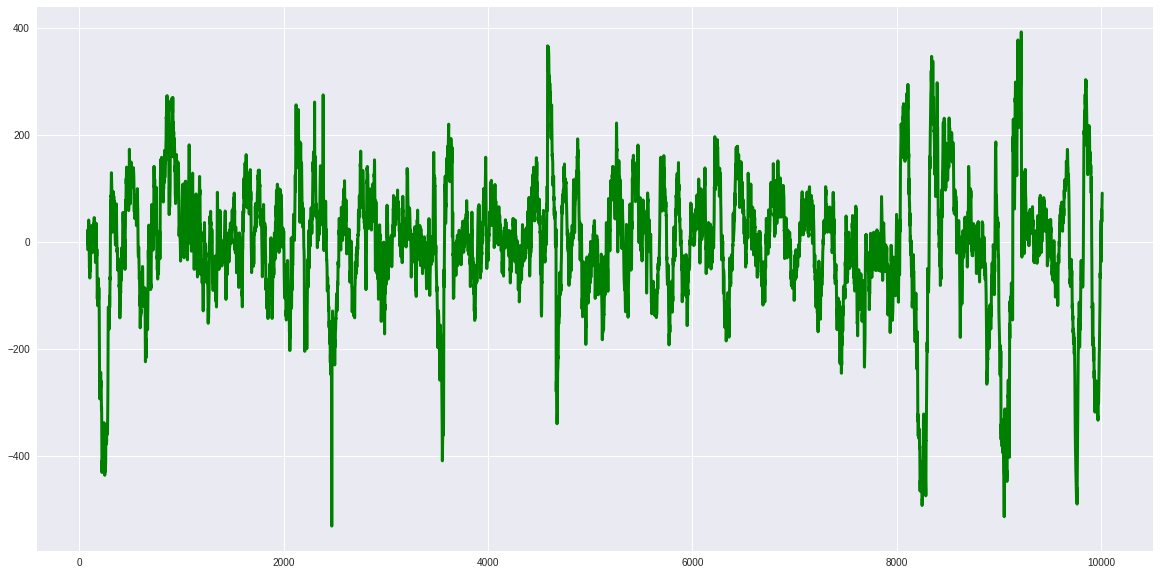

In [17]:
#plt.figure(1, figsize=(10,10))
# colors for the line plot
#colors = ['green', 'red', 'purple']

dzMA = df_z.rolling(84  ).mean()### 'blackman','bohman win_type='blackman'

### create a combine dataframe
#df = pd.DataFrame(dzMA)
#df['avg'] = ppgMVA
#plt.plot(ppg525, "g-", label='PPG at 525nm')
#plt.plot(ppgMVA, "r-", label='Moving Average of PPG at 525nm')
plt.figure(1, figsize=(20,10))
plt.plot(dzMA, "g-", label='PPG at 525nm',linewidth=3)
#dzMA.plot(color=colors, linewidth=3, figsize=(20,10))

# modify ticks size
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.legend(labels =['PPG at 525nm', 'Moving Average PPG' ], fontsize=14)

# title and labels
#plt.title('PPGs at Guan point in 2 hours', fontsize=20)
#plt.xlabel('Sample', fontsize=16)
#plt.ylabel('Amplitude', fontsize=16)

In [18]:
dzMA.isna().sum()

0    83
dtype: int64

In [19]:
len(z), L

(10010, 10011)

### Extract PPG from Baseline

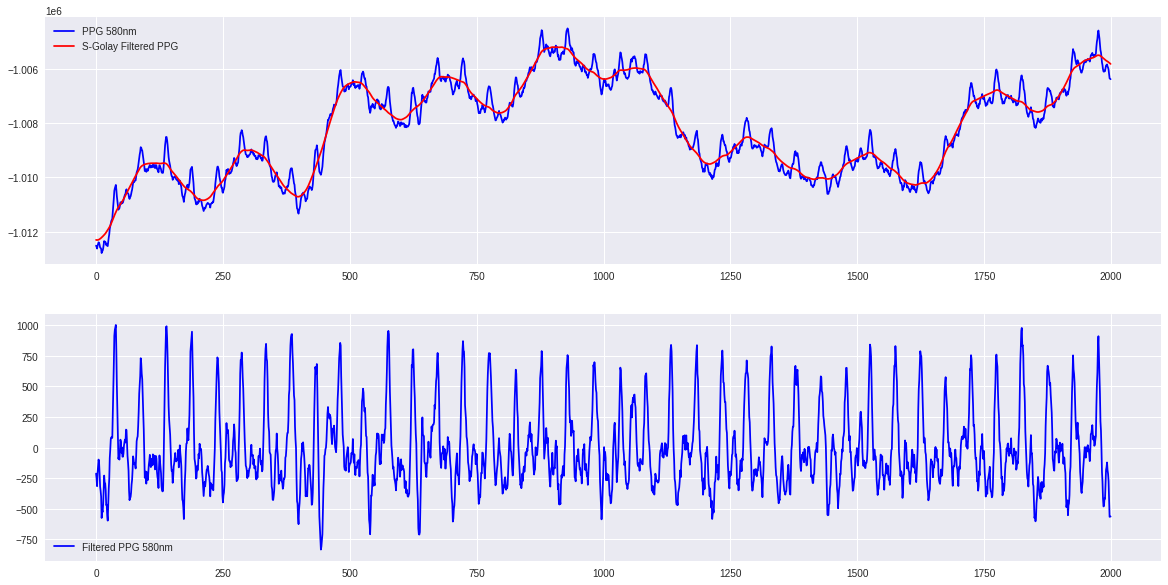

In [23]:
from scipy.signal import savgol_filter

filter_PPG1 = savgol_filter(filter_PPG, window_length = 211, polyorder =5)

bwrPPG1 = filter_PPG - filter_PPG1

plt.subplots(2, 1, figsize=(20,10))
L1, L2 = 383000, 385000
#L1, L2 = 0, len(bwrPPG1)
#plt.subplot(3, 1, 1)
plt.subplot(2, 1, 1)
plt.plot(filter_PPG[L1:L2], "b-", label="PPG " + str(name))
plt.plot(filter_PPG1[L1:L2], "r-", label="S-Golay Filtered PPG")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(bwrPPG1[L1:L2], "b-", label="Filtered PPG " + str(name))
plt.legend()

### Detect peaks filter signal

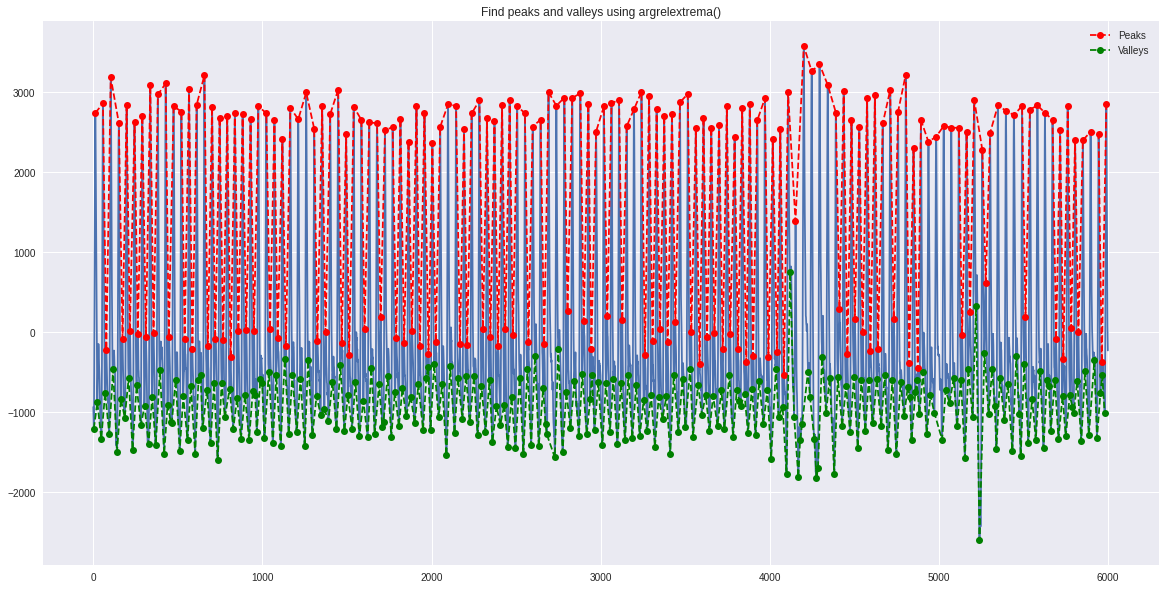

In [368]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

L1, L2 = 5000, 11000#len(bwrPPG1)
#L1, L2 = 386000, 388000#len(bwrPPG1)
#L1, L2 = 0, len(bwrPPG1)
# find peak max
peak_idxs1 = signal.argrelextrema(bwrPPG1, np.greater,order=10)#5 18
peak_idxs1 = peak_idxs1[0]
peak_idxs1 = [i  for i in peak_idxs1 if (i >=L1 and i <=L2)]

#find peak min
valley_idxs1 = signal.argrelextrema(bwrPPG1, np.less,order=5) #1
valley_idxs1 = valley_idxs1[0]
valley_idxs1 = [i  for i in valley_idxs1 if (i >=L1 and i <=L2)]
#plot main graph
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(bwrPPG1[L1:L2])
# plot peaks
peak_x1 = [i - L1 for i in peak_idxs1]
peak_y1 =  bwrPPG1[peak_idxs1]
ax.plot(peak_x1, peak_y1, marker='o', linestyle='dashed', color='r', label='Peaks')
# plot valleys
valley_x1 = [i - L1 for i in valley_idxs1]
valley_y1 =  bwrPPG1[valley_idxs1]
ax.plot(valley_x1, valley_y1, marker='o', linestyle='dashed', color='g', label='Valleys')

# Save graph to file.
plt.title('Find peaks and valleys using argrelextrema()')
plt.legend(loc='best')
#plt.savefig('argrelextrema.png')

In [347]:
new_peakidx1 = filter_peak(bwrPPG1, peak_idxs1)

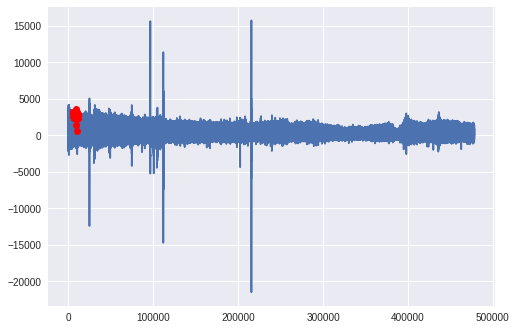

In [349]:
plt.plot(bwrPPG1)
plt.plot(new_peakidx1, bwrPPG1[new_peakidx1], marker='o',color='r')

In [351]:
signal = bwrPPG1[L1:L2]
index = [i - L1 for i in peak_idxs1]
new_peakidx1 = filter_peak(signal, index)

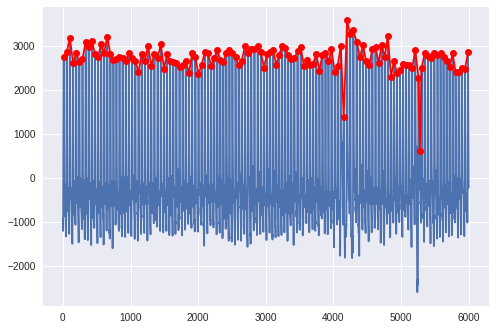

In [358]:
plt.plot(signal)
plt.plot(new_peakidx1, signal[new_peakidx1], marker='o',color='r')

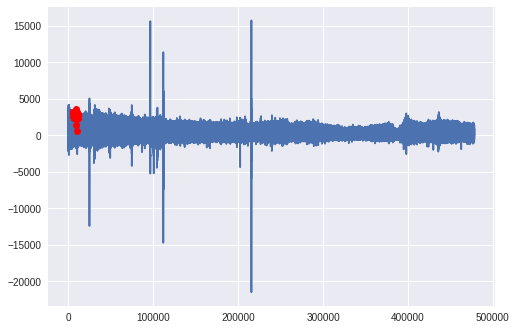

In [359]:
plt.plot(bwrPPG1)
index = [i + L1 for i in new_peakidx1]
plt.plot(index, bwrPPG1[index], marker='o',color='r')

In [375]:
new_peakidx1 = select_peaks(bwrPPG1[L1:L2], peak_idxs1,L=2000, L1=L1)

0
2000


IndexError: ignored

In [370]:
peak_idxs1

[5012,
 5057,
 5077,
 5103,
 5151,
 5173,
 5197,
 5216,
 5244,
 5263,
 5290,
 5311,
 5337,
 5356,
 5382,
 5428,
 5446,
 5475,
 5521,
 5540,
 5566,
 5586,
 5611,
 5657,
 5677,
 5702,
 5721,
 5747,
 5768,
 5792,
 5812,
 5837,
 5858,
 5883,
 5904,
 5930,
 5950,
 5976,
 6023,
 6045,
 6071,
 6090,
 6118,
 6139,
 6165,
 6212,
 6259,
 6306,
 6325,
 6353,
 6373,
 6401,
 6448,
 6469,
 6495,
 6513,
 6540,
 6585,
 6604,
 6632,
 6678,
 6699,
 6725,
 6770,
 6791,
 6816,
 6838,
 6864,
 6884,
 6911,
 6931,
 6958,
 6982,
 7005,
 7025,
 7051,
 7098,
 7145,
 7168,
 7192,
 7211,
 7237,
 7283,
 7304,
 7328,
 7348,
 7372,
 7393,
 7417,
 7436,
 7462,
 7481,
 7506,
 7552,
 7573,
 7598,
 7645,
 7666,
 7692,
 7738,
 7785,
 7804,
 7832,
 7880,
 7900,
 7927,
 7945,
 7973,
 8019,
 8039,
 8064,
 8109,
 8128,
 8154,
 8197,
 8241,
 8262,
 8286,
 8307,
 8331,
 8351,
 8376,
 8396,
 8422,
 8442,
 8469,
 8515,
 8536,
 8563,
 8585,
 8608,
 8629,
 8654,
 8673,
 8700,
 8722,
 8746,
 8766,
 8792,
 8812,
 8837,
 8861,
 8882,

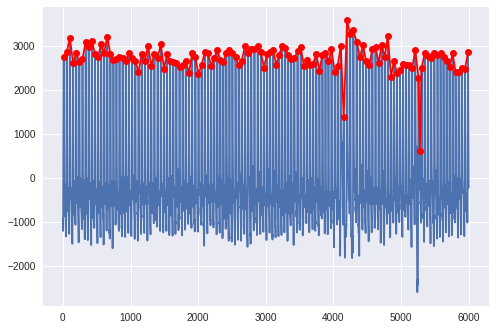

In [329]:
plt.plot(signal)
plt.plot(new_peakidx1, signal[new_peakidx1], marker='o',color='r')

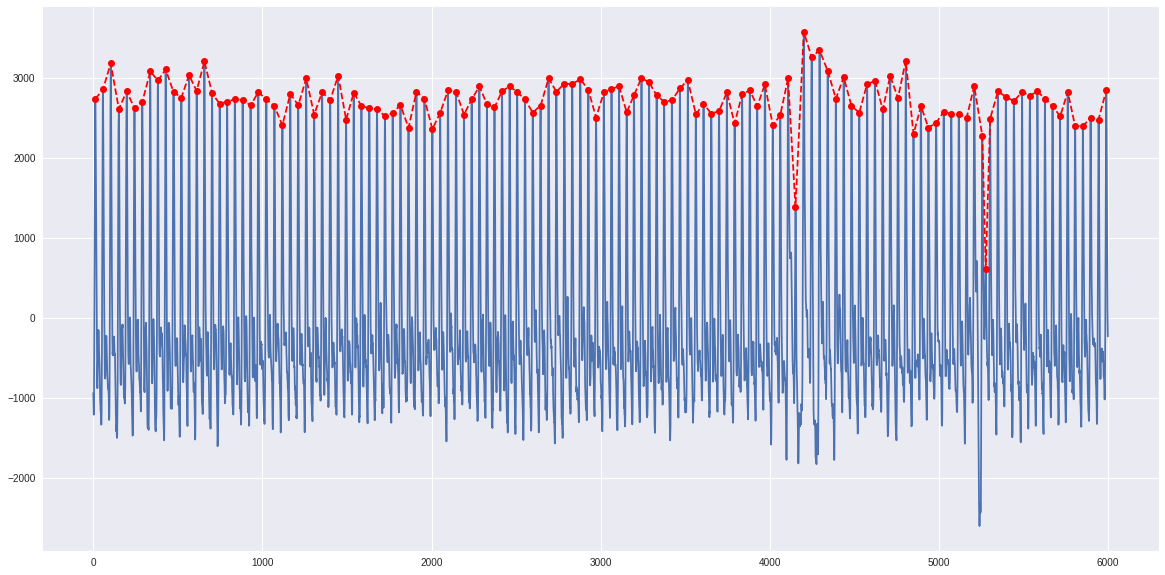

In [344]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(bwrPPG1[L1:L2])
# plot peaks
peak_x2 = [i - L1 for i in new_peakidx1]
peak_y2 =  bwrPPG1[new_peakidx1]
ax.plot(peak_x2, peak_y2, marker='o', linestyle='dashed', color='r', label='Peaks')

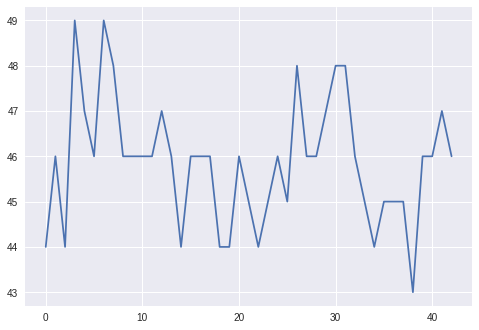

In [280]:
plt.plot(np.diff(peak_x2))

### Algorithm selecting peaks
* Step 1: Make a window to check the threshold to cut max peaks and sub peaks
** Check quantile of data windows 
  threshold $\theta$ = 0.5; this seperate almost max peaks and min peaks
** Need to check some wrong peaks in upset make a new threshold base on mean
* Step 2: Search with window for full signal


In [265]:
def filter_peak(signal, idx):
#signal = peak_y1
  s = signal[idx]
  high = .50
## get the firsth value threshold for 50%
  quant_df = pd.DataFrame(signal[idx]).quantile([high])
  
  lowset = s[s < quant_df[0][high]]
  #print(lowset)
  #new_signal = signal[s > np.mean(lowset)]
  new_idx = [i for i in idx if signal[i] > np.mean(lowset)]
  return new_idx




In [377]:
def select_peaks(signal, idx, L, L1): #idx absoluted positions
  #signal (np array) signal 
  # idx: index of signal peaks
  # Length L
  if len(signal) < L:
    new_idx = filter_peak(signal, idx)
  else:
    sub_L = [i for i in range(0,len(signal), L)]
    new_idx = [] 
    for l in sub_L[:-1]:
      print(l)
      #set N subset of signal with each subset has length L
      s=signal[l:l+L]
      #find index of peak in this subset s
      sub_idx = [i - l - L1 for i in idx if i < l+L and i >=l] # Not optimized
      print(sub_idx)
      idx1 = filter_peak(s, sub_idx)
      sub_idx = [i + l + L1 for i in idx1] # Not optimized
      new_idx.extend(idx1)
    # include the last subset
    l = sub_L[-1]
    s=signal[l:]
    sub_idx = [i for i in idx if i >=l]
    idx1 = filter_peak(s, sub_idx)
    new_idx.extend(idx1)
  return new_idx  
  


In [378]:
new_peakidx1 = select_peaks(bwrPPG1[L1:L2], peak_idxs1,L=2000, L1=L1)

0
[]
2000
[]


IndexError: ignored

In [305]:
L = 100
s = [i for i in range(15,100, 15)]
a = [i for i in s if i<45 and i > 15]
s[-1]

90

In [303]:
s.where(60)

AttributeError: ignored

In [237]:
signal = peak_y1
ow = .25
high = .50
quant_df = pd.DataFrame(signal).quantile([high])

print(quant_df[0][high])

2574.0975276195677


In [239]:
highset = signal[signal < quant_df[0][high]]
highset

array([2367.13923567, -119.51682556, 2570.12737529, -150.0878143 ,
       2549.17406098, -160.20116079,   46.45120425,  -52.9596884 ,
       -169.91981094,   39.97750168,  -39.91173554, -120.62146146,
       -150.54189519,  269.62920616,  139.57588537, -214.74964921,
       2511.44171317])

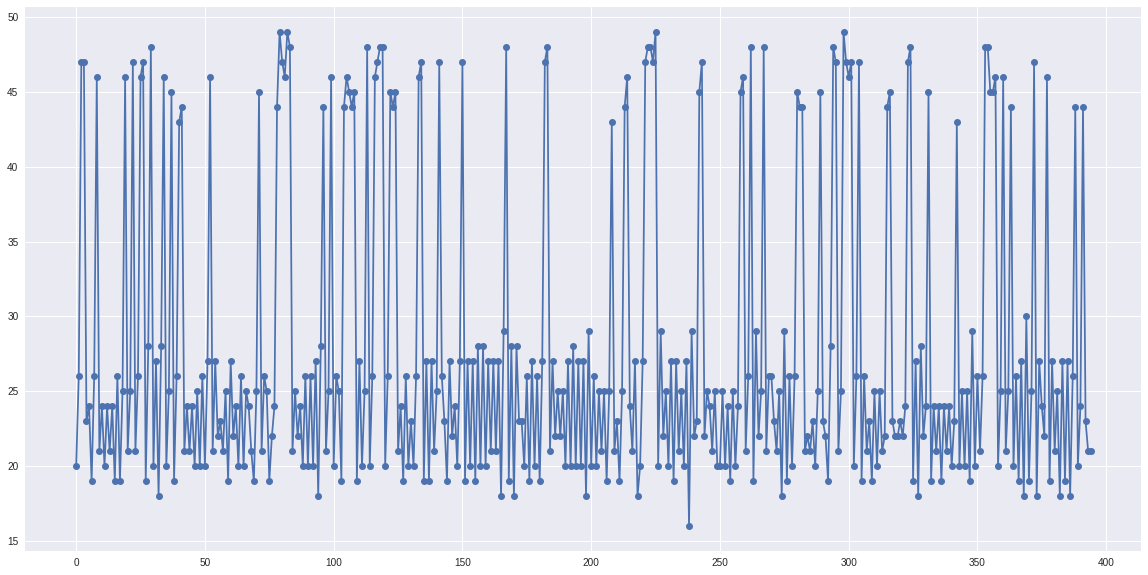

In [247]:
R_PTT = pd.DataFrame(np.diff(peak_idxs1))
#R_PTT = pd.DataFrame(np.array(peak_idxs1[0:-1]) )
#R_PTT = pd.DataFrame(np.gradient(valley_idxs1))
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(R_PTT,marker='o')

### Check amplitude of Peak to remove points


In [151]:
Amp = 250
peak_idxs2 = [p for p in peak_idxs1 if bwrPPG1[p] > Amp ]

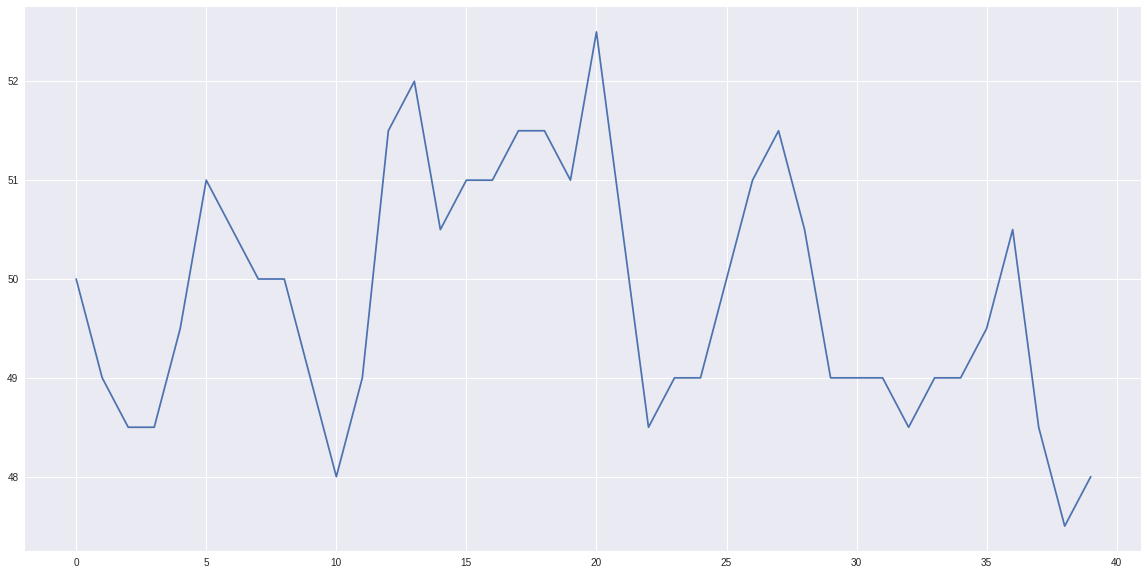

In [152]:
R_PTT2 = pd.DataFrame(np.gradient(peak_idxs2))
#R_PTT = pd.DataFrame(np.array(peak_idxs1[0:-1]) )
#R_PTT = pd.DataFrame(np.gradient(valley_idxs1))
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(R_PTT2)

In [138]:
len(peak_idxs2),np.median(R_PTT2)

(10013, 48.0)

In [41]:
np.median(R_PTT), np.mean(R_PTT)

(52.5, 0    50.375
 dtype: float64)

In [153]:

def filter_peaks(peakset, signal):
#signal = R_PTT
#peakset = peak_idxs1

  M = np.median(signal)
  i = 0
  L = len(peakset)
  new_peak=[]
  while (i<L-1):
    j=1
  #l = (peak_idxs1[i+j]-peak_idxs1[i])
    while ((peakset[i+j]-peakset[i]) <2/3*M):# and (peak_idxs1[i+j]-peak_idxs1[i]) < 4/3*M):
      j+=1
      if j>=L-1:
        break
  #print(j)
    new_peak.append(peakset[i])
     
    i+=j
  return new_peak

new_peakidx1 = filter_peaks(peak_idxs2, R_PTT2)

In [45]:
2/3*M, 4/3*M,peak_idxs1[i+j]-peak_idxs1[i]

(35.0, 70.0, 150)

In [46]:
i = 0; j=1
((peak_idxs1[i+j]-peak_idxs1[i]  > 2/3*M) and (peak_idxs1[i+j]-peak_idxs1[i] < 4/3*M))

True

In [56]:
i = 0; j=2
((peak_idxs1[i+j]-peak_idxs1[i]  < 2/3*M))#or (peak_idxs1[i+j]-peak_idxs1[i] > 4/3*M))

False

In [57]:
 (peak_idxs1[i+j]-peak_idxs1[i]  < 2/3*M), (peak_idxs1[i+j]-peak_idxs1[i] > 4/3*M) 

(False, True)

In [60]:
len(new_peakidx1), len(peak_idxs1)

(9925, 10201)

In [119]:
bwrPPG1[7]

438.58617653592955

In [ ]:
new_peakidx1

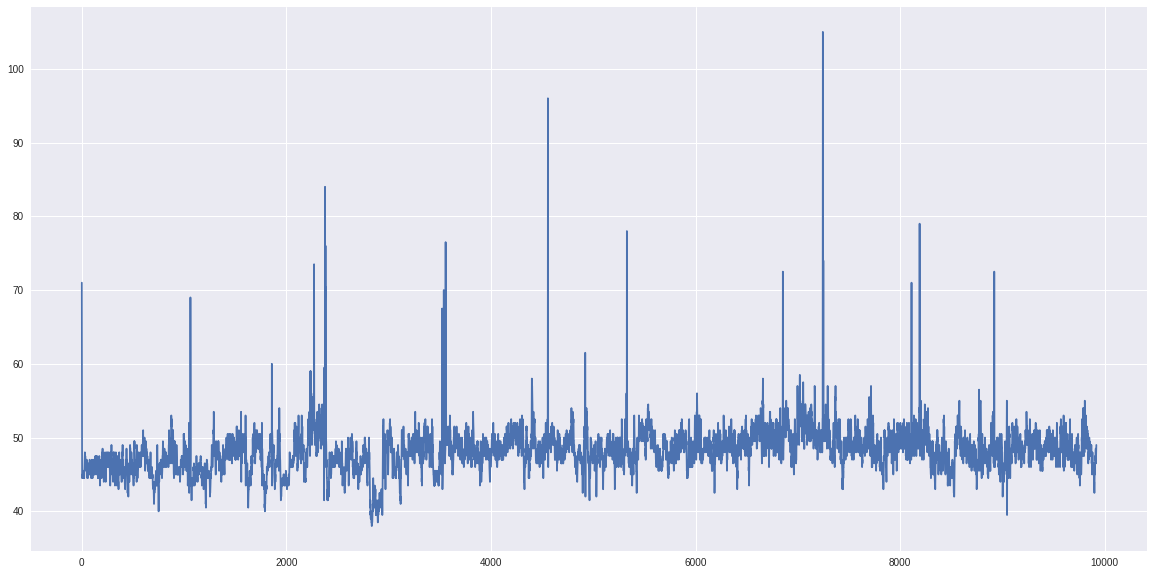

In [146]:
R_PTT1 = pd.DataFrame(np.gradient(new_peakidx1))
#R_PTT = pd.DataFrame(np.array(peak_idxs1[0:-1]) )
#R_PTT = pd.DataFrame(np.gradient(valley_idxs1))
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(R_PTT1)

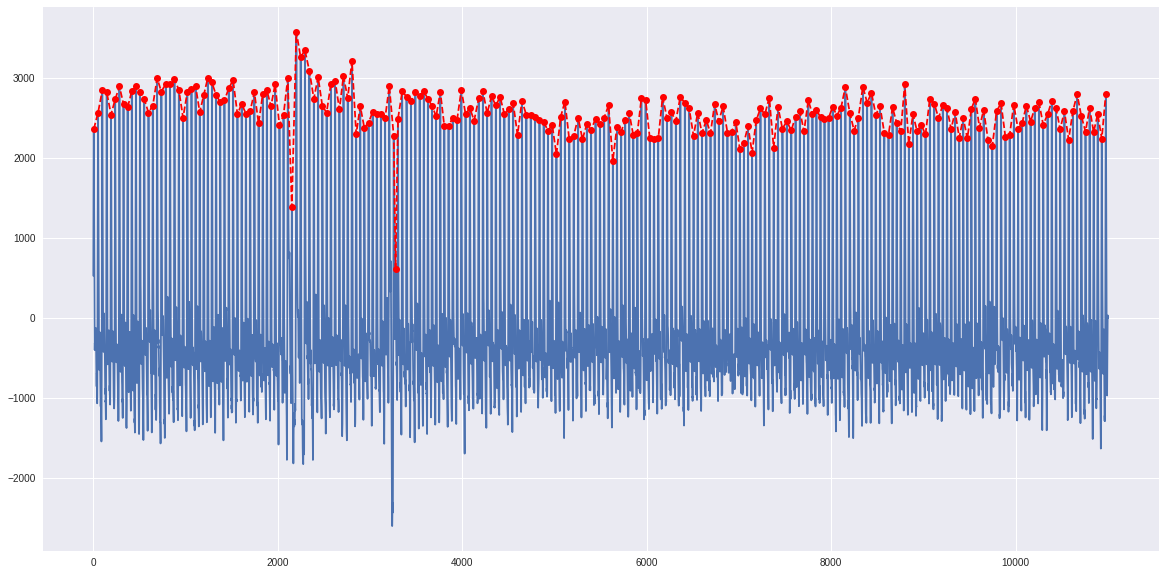

In [267]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(bwrPPG1[L1:L2])
# plot peaks
peak_x2 = [i - L1 for i in new_peakidx1]
peak_y2 =  bwrPPG1[new_peakidx1]
ax.plot(peak_x2, peak_y2, marker='o', linestyle='dashed', color='r', label='Peaks')

(array([25., 30., 35., 40., 45., 50., 55., 60., 65.]),
 <a list of 9 Text major ticklabel objects>)

<Figure size 720x720 with 0 Axes>

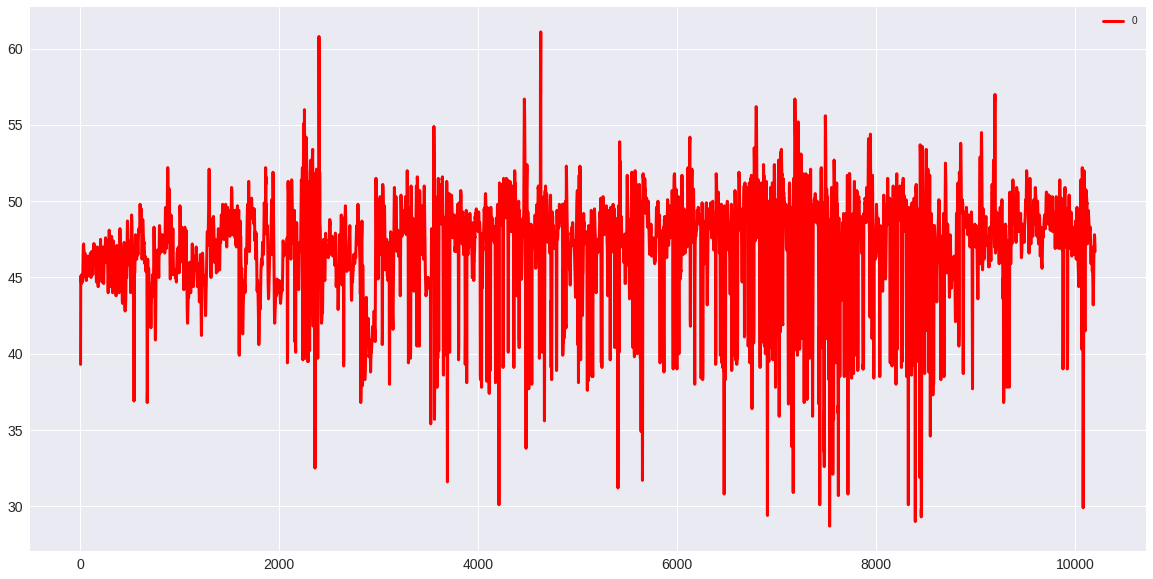

In [282]:
plt.figure(1, figsize=(10,10))
# colors for the line plot
colors = ['green', 'red', 'purple']

#dzMA = R_PTT.rolling(2000, win_type='blackman' ).mean()### 'blackman','bohman'win_type='None'
dzMA = R_PTT.rolling(5 ).mean()### 'blackman','bohman'win_type='None'
### create a combine dataframe
#df = pd.DataFrame(dzMA,idx, ignore_index=True)
#df['avg'] = ppgMVA
#plt.plot(ppg525, "g-", label='PPG at 525nm')
#plt.plot(ppgMVA, "r-", label='Moving Average of PPG at 525nm')
dzMA.plot(color=colors[1], linewidth=3, figsize=(20,10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [182]:
len(R_PTT), len(dzMA)

(25014, 25014)

In [187]:
dzMA

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
25009,19.263528
25010,19.263568
25011,19.263608
25012,19.263648


In [151]:
R_PTT.describe()

,0
count,22137.000000
mean,21.601075
std,4.478102
min,6.000000
25%,18.000000
50%,23.000000
75%,24.500000
max,62.500000


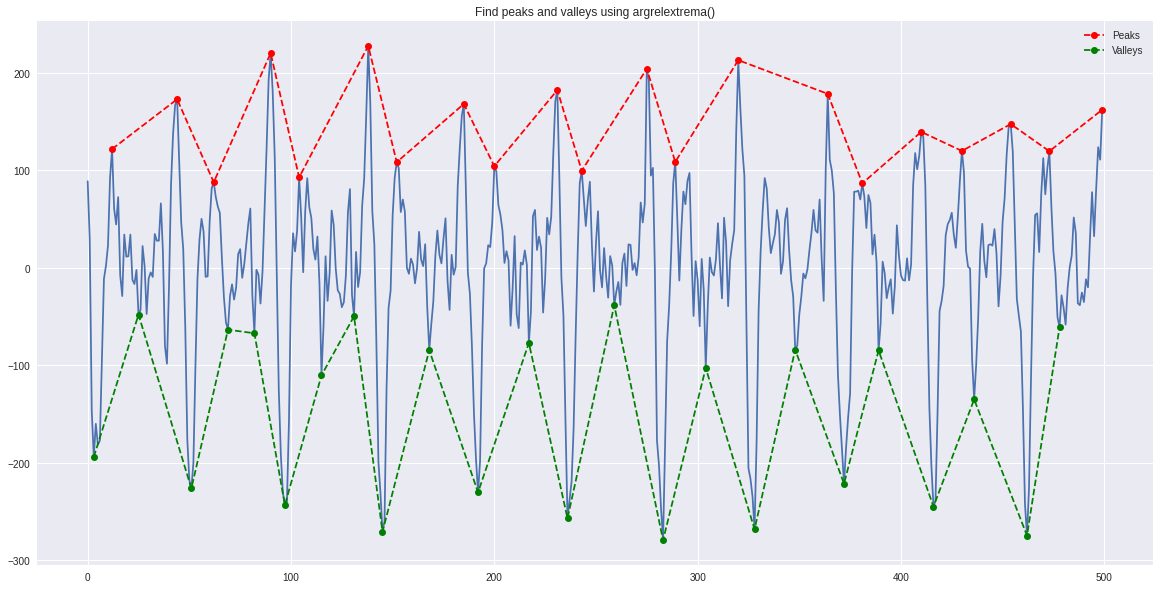

In [176]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

L1, L2 = 7000, 7500#len(bwrPPG1)
# find peak max
d2_bwrPPG1 = np.gradient(np.gradient(bwrPPG1))
peak_idxs1 = signal.argrelextrema(d2_bwrPPG1, np.greater,order=10)
peak_idxs1 = peak_idxs1[0]
peak_idxs1 = [i  for i in peak_idxs1 if (i >=L1 and i <=L2)]

#find peak min
valley_idxs1 = signal.argrelextrema(d2_bwrPPG1, np.less,order=10)
valley_idxs1 = valley_idxs1[0]
valley_idxs1 = [i  for i in valley_idxs1 if (i >=L1 and i <=L2)]
#plot main graph
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(d2_bwrPPG1[L1:L2])
# plot peaks
peak_x1 = [i - L1 for i in peak_idxs1]
peak_y1 =  d2_bwrPPG1[peak_idxs1]
ax.plot(peak_x1, peak_y1, marker='o', linestyle='dashed', color='r', label='Peaks')
# plot valleys
valley_x1 = [i - L1 for i in valley_idxs1]
valley_y1 =  d2_bwrPPG1[valley_idxs1]
ax.plot(valley_x1, valley_y1, marker='o', linestyle='dashed', color='g', label='Valleys')

# Save graph to file.
plt.title('Find peaks and valleys using argrelextrema()')
plt.legend(loc='best')
#plt.savefig('argrelextrema.png')

###Reading Glucose

In [67]:
from pandas import read_csv
file_path = file_path = 'drive/My Drive/Dataset/GlucoseLong02_02April.csv'
#file_path = file_path = 'drive/My Drive/Dataset/GlucoseLong02_12Mar.csv'
dataset = read_csv(file_path,
                   
                   parse_dates=['Timestamp (YYYY-MM-DDThh:mm:ss)'],
                   index_col=['Timestamp (YYYY-MM-DDThh:mm:ss)'],
                   skiprows= [i for i in range(1,11)],
                   na_values= ['nan'])

 ### Find index in time series

In [68]:
import numpy
def find_index(dataset, time):
   s = [index for index in range(len(dataset.index.values)) if dataset.index.values[index] == numpy.datetime64(time)]
   return s[0]

In [72]:
x_start = find_index(dataset, '2021-04-02T15:14:40')  #2021-04-02T15:09:40  2021-04-01T13:59:40 2021-04-01T13:19:41 2021-03-25T17:44:37
x_stop = find_index(dataset, '2021-04-02T17:19:40') #2021-04-02T17:19:40   2021-04-01T16:44:41 2021-04-02T18:49:42

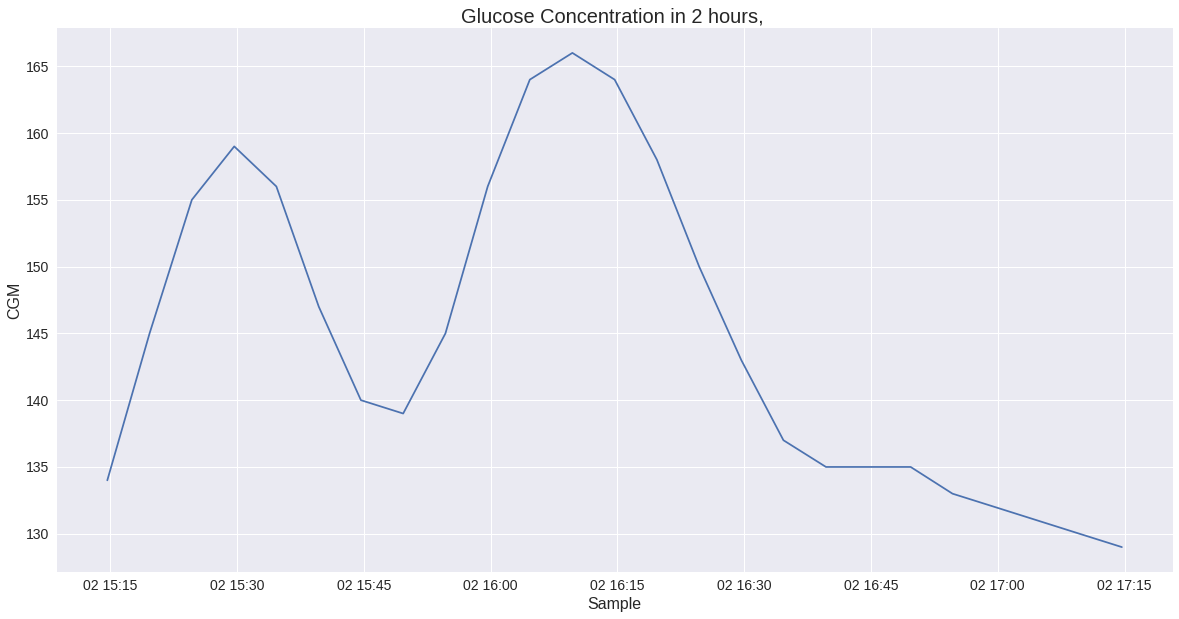

In [73]:
df_glu = dataset['Glucose Value (mg/dL)'][x_start:x_stop]
plt.figure(1, figsize=(20,10))
plt.plot(df_glu)
# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# title and labels
plt.title('Glucose Concentration in 2 hours, ', fontsize=20)
plt.xlabel('Sample', fontsize=16)
plt.ylabel('CGM', fontsize=16)
plt.show()